# Geovisual Analytics for Shenzhen Taxi Trajectories

This demonstration shows the visual analytics for the Shenzhen taxi trajectories, including histogram distribution graph, heatmaps for different constraints, and heatmap with time information.


Here we'll explore taxi trip data collected from Shenzhen. 

Data information was described in Cheng et al. 2019.
 
Cheng, B., Qian, S., Cao, J., Xue, G., Yu, J., Zhu, Y., ... & Zhang, T. (2019, April). STL: Online Detection of Taxi Trajectory Anomaly Based on Spatial-Temporal Laws. In International Conference on Database Systems for Advanced Applications (pp. 764-779). Springer, Cham.

https://link.springer.com/chapter/10.1007/978-3-030-18579-4_45




## Prepare the shenzhen taxi dataset

### Set upt the envionment and import libraries

In [1]:
from __future__ import division 
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
plt.style.use('ggplot')
import os
import glob
import datashader as ds
import datashader.transfer_functions as tf

import bokeh, bokeh.plotting, bokeh.models
from bokeh.io import output_notebook, show
output_notebook()

from bokeh.plotting import figure, output_notebook, show

#from datashader import transfer_functions as tf
from datashader.colors import Greys9

from datashader.bokeh_ext import InteractiveImage
from functools import partial
from datashader.utils import export_image
from datashader.colors import colormap_select, Greys9, Hot, viridis, inferno
from IPython.core.display import HTML, display

%matplotlib inline

import folium


Loading BokehJS ...

### Prepare the dataset in the data directory
This takes several seconds. Here we use one file as example.

In [2]:
import requests
import shutil
import os
import zipfile

#req = requests.get('https://github.com/cybergis/cybergis-jupyter-notebook-repo/blob/master/geospatial/taxi.zip', stream=True)
#with open('taxi.zip', 'wb') as file:
#    shutil.copyfileobj(req.raw, file)
    
if not os.path.exists('./data'):
    os.mkdir('./data')
    
with zipfile.ZipFile('taxi.zip', 'r') as file:
    file.extractall('./data')

os.listdir('./data/taxi')

['.DS_Store', 'TRK20090923.txt']

### Read the dataset using csv

In [3]:
path = r'./data/'
#taxi_files = glob.glob(os.path.join(path, "*.txt")) 


filename = './data/taxi/TRK20090923.txt'
column_names = ['taxi_id', 'date_time', 'longitude', 'latitude', 'speed', 'direction', 'occupied','other']
#df_master = pd.concat(pd.read_csv(f, names=column_names) for f in taxi_files)  #glue all data into the dataframe
df_master = pd.read_csv(filename, names=column_names)
df_master['date_time'] = pd.to_datetime(df_master.date_time) # Correct the type in date_time column

### Show the amount of data and the example of taxi trajectory Data and 


In [4]:
print(len(df_master))
df_master.head(10)

1007097


,taxi_id,date_time,longitude,latitude,speed,direction,occupied,other
0,B001B1,2009-09-23 21:32:56,114.06070,22.52170,28,0,0,0
1,B001B1,2009-09-23 21:33:51,114.06070,22.52170,0,0,0,0
2,B001B1,2009-09-23 21:34:46,114.06068,22.52165,0,0,0,0
3,B001B1,2009-09-23 21:35:41,114.06084,22.52182,5,0,0,0
4,B001B1,2009-09-23 21:36:36,114.06060,22.52258,4,0,0,0
5,B001B1,2009-09-23 21:37:31,114.05995,22.52545,17,0,0,0
6,B001B1,2009-09-23 21:38:26,114.06075,22.52567,4,0,0,0
7,B001B1,2009-09-23 21:38:50,114.06075,22.52567,0,0,1,31
8,B001B1,2009-09-23 21:39:45,114.06316,22.52787,26,0,1,31
9,B001B1,2009-09-23 21:40:40,114.06580,22.53153,40,0,1,31


In [5]:
df = df_master.copy() # Allows you to 'restart' the worksheet without waiting to recreate dataframe

### Use numpy functions for the distance formula

In [6]:
def gps_dist(a, b, c, d):    
    '''Compute the distance (in meters) between two gps locations. Input is assumed to be a = longitude, b = latitude, etc.'''
    r = 0.0174533  # 1 degree in radians
    return 2 * 6371000 * np.arcsin( np.sqrt( # https://en.wikipedia.org/wiki/Haversine_formula
        np.sin(r*(d - b)/2.0)**2 + np.cos(r*b) * np.cos(r*d) * np.sin(r*(c - a)/2.0)**2))

## Visualization of the whole taxi trajectory dataset

### Define the dataset which the occupied status is 1, and locates in the boundary.


In [7]:
maindt = df[df.occupied == 1]
maindt = df[abs(df.longitude -114.05) <= 1]
maindt = maindt[abs(maindt.latitude - 22.5) <= 1]


### Visual the whole dataset

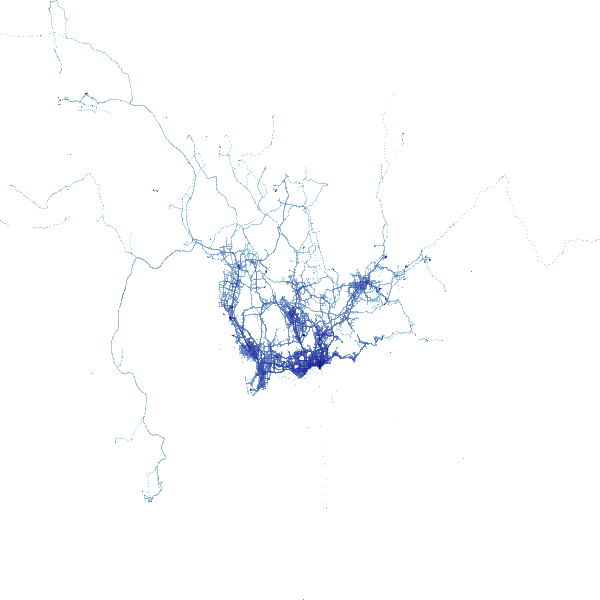

In [8]:
cvs = ds.Canvas(plot_width=600, plot_height=600)
agg = cvs.points(maindt,'longitude','latitude')
img = tf.shade(agg, cmap=['lightblue','darkblue'],how='log')
img

### zooming in the whole taxi trajectory dataset in Shenzhen

(113.7004, 114.39993) (22.35043, 23.04925)


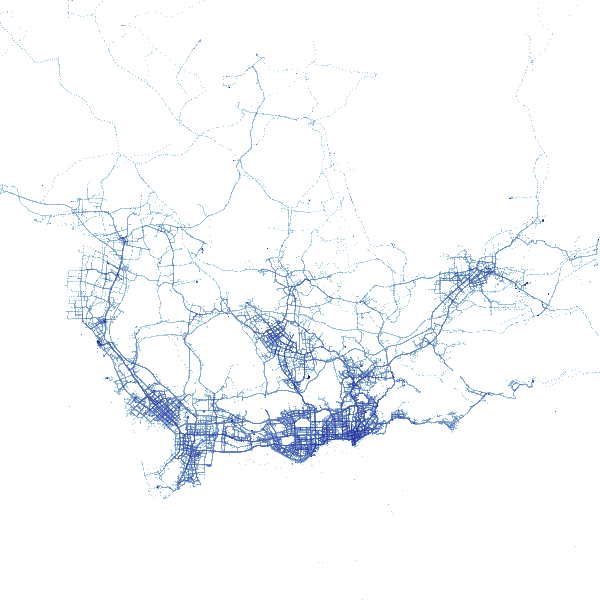

In [9]:

maindt = df[abs(df.longitude -114.05) <= 0.35]
maindt = maindt[abs(maindt.latitude - 22.70) <= 0.35]


xrange = np.min(maindt['longitude']),np.max(maindt['longitude'])

yrange = np.min(maindt['latitude']),np.max(maindt['latitude'])

print (xrange,yrange)

xxrange = (113.673267, 114.646188)
yyrange  = (22.365089, 22.864404)

#cvs = ds.Canvas(x_range=xxrange, y_range=yyrange,plot_width=600, plot_height=600)
cvs = ds.Canvas(x_range=xrange, y_range=yrange,plot_width=600, plot_height=600)
agg = cvs.points(maindt,'longitude','latitude')
img = tf.shade(agg, cmap=['lightblue','darkblue'],how='log')
img


### Define the histogram function

In [10]:
def histogram(x,colors=None):
    hist,edges = np.histogram(x, bins=100)
    p = figure(y_axis_label="Pixels",
               tools='', height=300, outline_line_color=None,
               min_border=0, min_border_left=0, min_border_right=0,
               min_border_top=0, min_border_bottom=0)
    p.quad(top=hist[1:], bottom=0, left=edges[1:-1], right=edges[2:])
    print("min: {}, max: {}".format(np.min(x),np.max(x)))
    show(p)
    

### Define the histogram distribution

In [11]:
histogram(agg.values)

min: 0, max: 7018


### Define the histogram distribution using log1p

min: 0.0, max: 8.856376036730422


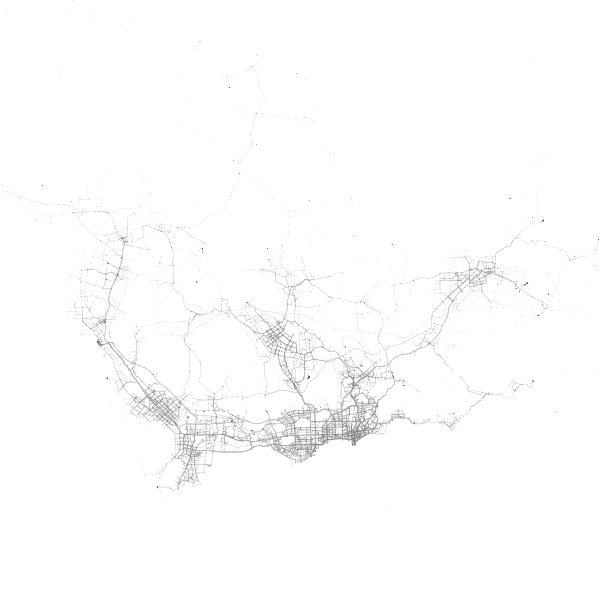

In [12]:

Greys9_r = list(reversed(Greys9))[:-2]

histogram(np.log1p(agg.values))

tf.shade(agg, cmap=Greys9_r, how='log')

### Define the histogram distribution using eq_hist

min: 0.9276, max: 1.0


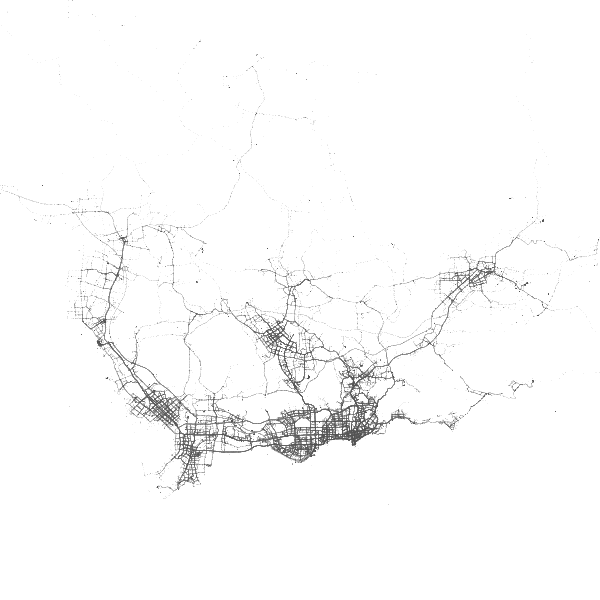

In [13]:
histogram(tf.eq_hist(agg.values))

#cmapOrange = ['darkred', 'red', 'orangered', 'darkorange', 'orange', 'gold', 'yellow', 'white']
    
tf.shade(agg, cmap=Greys9_r, how='eq_hist')

### Show the heatmap using eq_hist

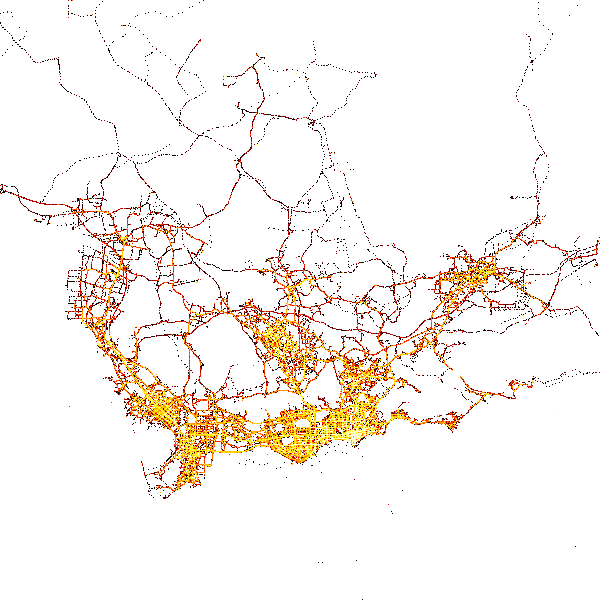

In [14]:
#cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
cvs = ds.Canvas(plot_width=600, plot_height=600)
#agg = cvs.points(df, 'dropoff_x', 'dropoff_y',  ds.count('passenger_count'))
agg = cvs.points(maindt,'longitude','latitude')
img = tf.shade(agg, cmap=Hot, how='eq_hist')
tf.dynspread(img, threshold=0.5, max_px=4)


### Show the heatmap with the aggregation percent great than 90% 

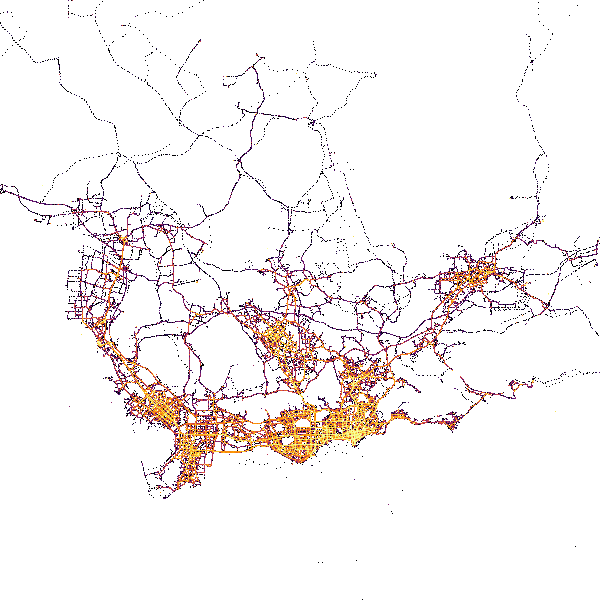

In [15]:
cvs = ds.Canvas(plot_width=600, plot_height=600)
agg = cvs.points(maindt, 'longitude','latitude')
img = tf.shade(agg.where(agg>np.percentile(agg,90)), cmap=inferno, how='eq_hist')
tf.dynspread(img, threshold=0.3, max_px=4)


## HeatMap for shenzhen taxi dataset  with time information
### extract hour from the timestamp column to create an time_hour column, and show the example of the dataset

In [16]:
#maindt['hour'] = maindt['timestamp'].dt.hour
maindt['hour'] = pd.to_datetime(maindt['date_time']).dt.hour.astype('category')
maindt.head(5)

,taxi_id,date_time,longitude,latitude,speed,direction,occupied,other,hour
0,B001B1,2009-09-23 21:32:56,114.06070,22.52170,28,0,0,0,21
1,B001B1,2009-09-23 21:33:51,114.06070,22.52170,0,0,0,0,21
2,B001B1,2009-09-23 21:34:46,114.06068,22.52165,0,0,0,0,21
3,B001B1,2009-09-23 21:35:41,114.06084,22.52182,5,0,0,0,21
4,B001B1,2009-09-23 21:36:36,114.06060,22.52258,4,0,0,0,21


### define 24 clolrs for 24 hours, show  the heatmap with time information

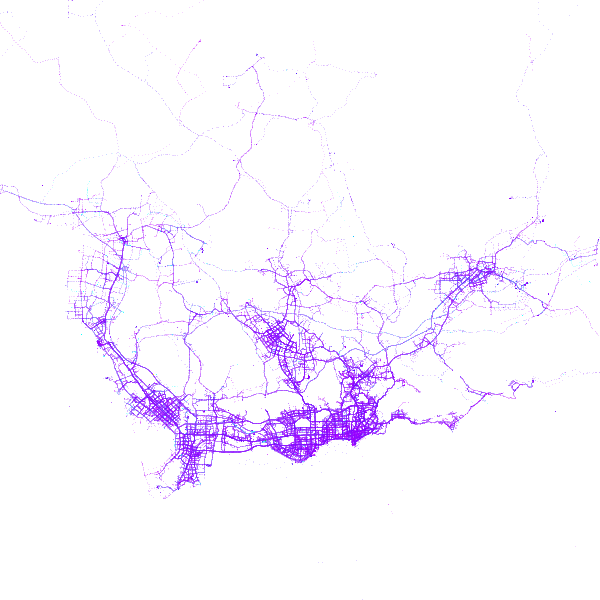

In [17]:

colors = ["#FF0000","#FF3F00","#FF7F00","#FFBF00","#FFFF00","#BFFF00","#7FFF00","#3FFF00",
          "#00FF00","#00FF3F","#00FF7F","#00FFBF","#00FFFF","#00BFFF","#007FFF","#003FFF",
          "#0000FF","#3F00FF","#7F00FF","#BF00FF","#FF00FF","#FF00BF","#FF007F","#FF003F",]


cvs = ds.Canvas(plot_width=600, plot_height=600)
agg = cvs.points(maindt, 'longitude','latitude',ds.count_cat('hour'))
#agg = cvs.points(df, dataset+'_x', dataset+'_y', ds.count_cat('hour'))
img = tf.shade(agg, color_key=colors)
tf.dynspread(img, threshold=0.3, max_px=4)
